In [1]:
from tqdm import tqdm
import config 
from config import initial_transforms
from utils import unnormalize, show_some, generate_context
from dataset import ImageDataset
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2BD1B165-EC09-3F68-BCE4-8FE4E70CA7E2> /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <9C467D80-5BAC-3156-B480-F0FF7E45DEF2> /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
from torch.utils.data import DataLoader

    
train_ds = ImageDataset("dataset/Train", initial_transforms, "dataset/discription.json")
train_dl = DataLoader(train_ds, batch_size=config.TRAIN_BATCH_SIZE, shuffle=True)

test_ds = ImageDataset("dataset/Test", initial_transforms, "dataset/discription.json")
test_dl = DataLoader(train_ds, batch_size=config.EVAL_BATCH_SIZE, shuffle=True)


/Users/mohamedmafaz/Desktop/Stable-diffusion/sd/utils.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


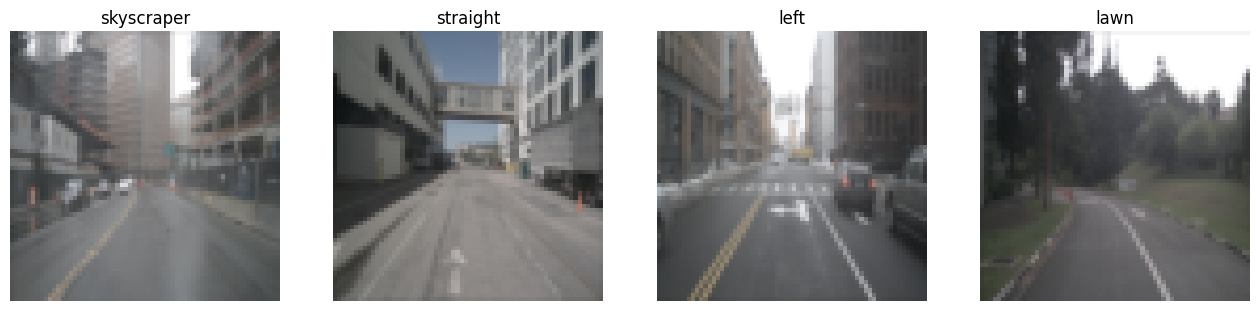

In [4]:
show_some(train_dl)

In [5]:
sample_image = next(iter(train_dl))[0]
print("Input shape:", sample_image.shape)

Input shape: torch.Size([4, 3, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Noise + Original iamge')

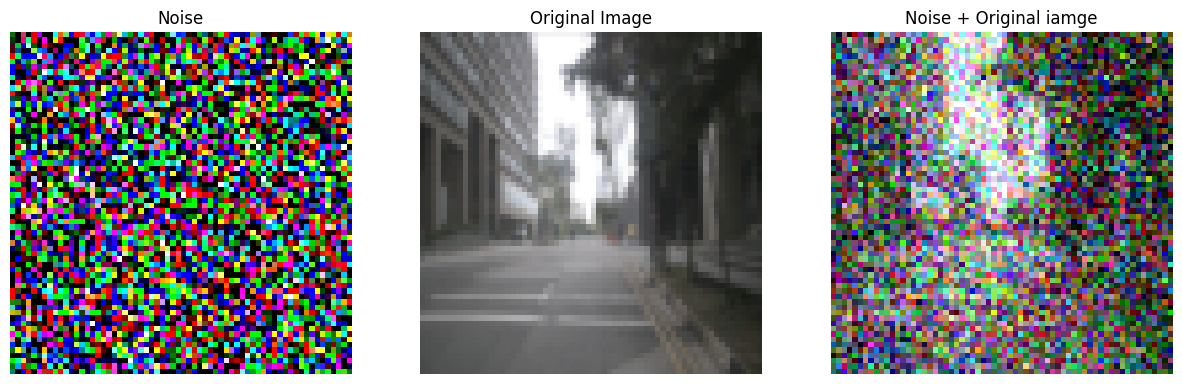

In [6]:
from ddpm import DDPMSampler
import torch

generator = torch.Generator(device=config.DEVICE)

noise_scheduler = DDPMSampler(generator=generator)
# noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([200])
noise, noisy_image = noise_scheduler.add_noise(sample_image, timesteps)

inv_norm_noisy = unnormalize(noisy_image.clone())
inv_norm_original = unnormalize(sample_image.clone())

plt.figure(figsize=(15,15))

plt.subplot(1,3,1)
plt.imshow(noise[0].permute(1,2,0))
plt.axis("off")
plt.title("Noise")

plt.subplot(1,3,2)
plt.imshow(inv_norm_original[0].permute(1,2,0))
plt.axis("off")
plt.title("Original Image")


plt.subplot(1,3,3)
plt.imshow(inv_norm_noisy[0].permute(1,2,0))
plt.axis("off")
plt.title("Noise + Original iamge")


In [7]:
noise_and_image = inv_norm_noisy[0].permute(1,2,0)
orignal_image = inv_norm_original[0].permute(1,2,0)
noise_added = noise[0].permute(1,2,0)

In [44]:
from transformers import CLIPTokenizer
tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [46]:
from clip import CLIP
clip = CLIP().to("cpu")

prompt = "hello kitty"
uncond_prompt = ""

context = generate_context(tokenizer, clip, prompt=[prompt], uncond_prompt=[uncond_prompt])

In [11]:
# output_cond, output_uncond = model_output.chunk(2)
# model_output = cfg_scale * (output_cond - output_uncond) + output_uncond

In [12]:
from pipeline import get_time_embedding

time_embedding = get_time_embedding(500).to("cpu")
context = generate_context(tokenizer, clip, "hello kitty")

In [13]:
import torch.nn.functional as F
from diffusion import Diffusion
from pipeline import get_time_embedding

diffusion = Diffusion()

bs = noise.shape[0]

latents_shape = (bs, 4, config.LATENT_SIZE, config.LATENT_SIZE)

latents = torch.randn(latents_shape, generator=generator, device="cpu")

# context = generate_context("hello kitty")

context = torch.cat([context]*2)

# time_embedding = get_time_embedding(500).to("cpu")

noise_pred_latent = diffusion(latents, context, time_embedding)

In [14]:
noise_pred_latent.shape

torch.Size([4, 4, 8, 8])

In [16]:
from decoder import VAE_Decoder
from torch.cuda.amp import autocast

with torch.amp.autocast("cpu"):
    # x = torch.rand(1, 4, 64, 64)
    decoder = VAE_Decoder()
    noise_pred = decoder(noise_pred_latent)
    # noise_pred = decoder(x)

noise_pred.shape

torch.Size([4, 3, 64, 64])

In [17]:
noise = noise[0]

loss = F.mse_loss(noise_pred, noise)
loss

/var/folders/3p/xlr6tgyx4t980qpxnnrs12kc0000gn/T/ipykernel_76104/1755674906.py:3: UserWarning: Using a target size (torch.Size([3, 64, 64])) that is different to the input size (torch.Size([4, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(noise_pred, noise)


tensor(1.1788, grad_fn=<MseLossBackward0>)

In [19]:
noise_image = noise_pred[0].squeeze(0).permute(1, 2, 0)  # Adjust shape
noise_image = noise_image.to(torch.float32)  # Convert to Float32
noise_image_np = noise_image.detach().numpy() 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 63.5, 63.5, -0.5)

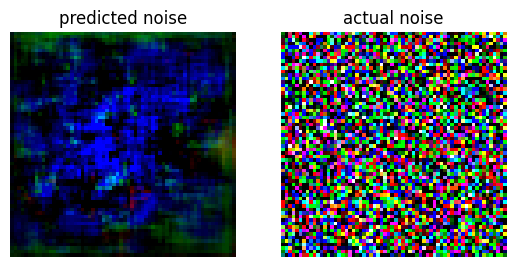

In [20]:
plt.subplot(1,2,1)
noise_image = noise_pred[0].squeeze(0).permute(1, 2, 0)  # Adjust shape
noise_image = noise_image.to(torch.float32)  # Convert to Float32
noise_image_np = noise_image.detach().numpy() 

plt.imshow(noise_image_np)
plt.title("predicted noise")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(noise.squeeze(0).permute(1,2,0).detach().numpy())
plt.title("actual noise")
plt.axis("off")


In [21]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(diffusion.parameters(), lr=config.LEARNING_RATE)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.LR_WARMUP_STEPS,
    num_training_steps=(len(train_dl) * config.EPOCHS),
)

In [42]:
from encoder import VAE_Encoder
from decoder import VAE_Decoder

import model_converter

state_dict = model_converter.load_from_standard_weights("../data/v1-5-pruned-emaonly.ckpt", config.DEVICE)

# Initialize the decoder
decoder = VAE_Decoder().to(config.DEVICE)
decoder.load_state_dict(state_dict['decoder'], strict=True)

# Initialize the encoder
encoder = VAE_Encoder().to()
encoder.load_state_dict(state_dict['encoder'], strict=True)  # This should load into the encoder

<All keys matched successfully>

In [43]:
# will not be using this
# from diffusion import Diffusion
# diffusion = Diffusion().to('cpu')
# diffusion.load_state_dict(state_dict['diffusion'], strict=True)

<All keys matched successfully>

In [56]:
generate_context(tokenizer, clip, ('skyscraper', 'building', 'beach')).shape

torch.Size([4, 77, 768])

In [60]:
time_embedding.shape

torch.Size([1, 320])

In [ ]:
from clip import CLIP

clip = CLIP().to(config.DEVICE)

In [65]:
global_step = 0

for epoch in range(2):
    progress_bar = tqdm(total=len(train_dl))
    progress_bar.set_description(f"Epoch {epoch}")

    for step, batch in enumerate(train_dl):
        clean_images = batch[0] # for now, didnt add the text description to images yet
        timestep = torch.randint(0, noise_scheduler.num_train_timesteps, (1,), device=clean_images.device) # One time step constant for each batch

        bs = clean_images.shape[0]
        latents_shape = (bs, 4, config.LATENT_SIZE, config.LATENT_SIZE)

        input_image_tensor = rescale(clean_images, (0, 255), (-1, 1))

        encoder_noise = torch.randn(latents_shape, generator=generator, device=clean_images.device)
        latents = encoder(input_image_tensor, encoder_noise)

        noise, noisy_latents = noise_scheduler.add_noise(latents, timestep)

        context = generate_context(tokenizer, clip, batch[1])
        context = torch.cat([context]*bs)

        time_embedding = get_time_embedding(timestep).to(clean_images.device.type)

        noise_pred_latent = diffusion(latents, context, time_embedding)

        loss = F.mse_loss(noise_pred_latent, noise)

        loss = loss / config.GRADIENT_ACCUMULATION_STEPS

        loss.backward()

        # Perform optimizer step only after accumulating enough gradients
        if (step + 1) % config.GRADIENT_ACCUMULATION_STEPS == 0 or (step + 1) == len(train_dl):
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(diffusion.parameters(), max_norm=1.0)

            # Optimizer step
            optimizer.step()
            lr_scheduler.step()

            # Zero the gradients
            optimizer.zero_grad()

        # Progress and logging
        progress_bar.update(1)
        logs = {
            "loss": loss.detach().item(),
            "lr": lr_scheduler.get_last_lr()[0],
            "step": global_step
        }
        progress_bar.set_postfix(**logs)

        # Update global step
        global_step += 1

    if (epoch + 1) % config.SAVE_MODEL_EPOCHS == 0 or epoch == config.EPOCHS - 1:
        torch.save(diffusion.state_dict(), "data/diffusion.pth")

Epoch 0: 100%|██████████| 2/2 [05:11<00:00, 155.85s/it, loss=1.07, lr=4e-7, step=1]
